In [ ]:
# Author: Janssen Kotah
# snRNAseq analysis for WT/SHIP1 KO mice as part of Matera et al. project
# harmony integration is based on package vignette: https://portals.broadinstitute.org/harmony/articles/quickstart.html
# Code adapted from Eggen lab pipelines, adapting templates from Mirjam Koster, Thomas Rust, Astrid Alsema, etc


In [1]:
library(Seurat)
library(dplyr)
library(patchwork)
library(ggplot2)
library(harmony)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp



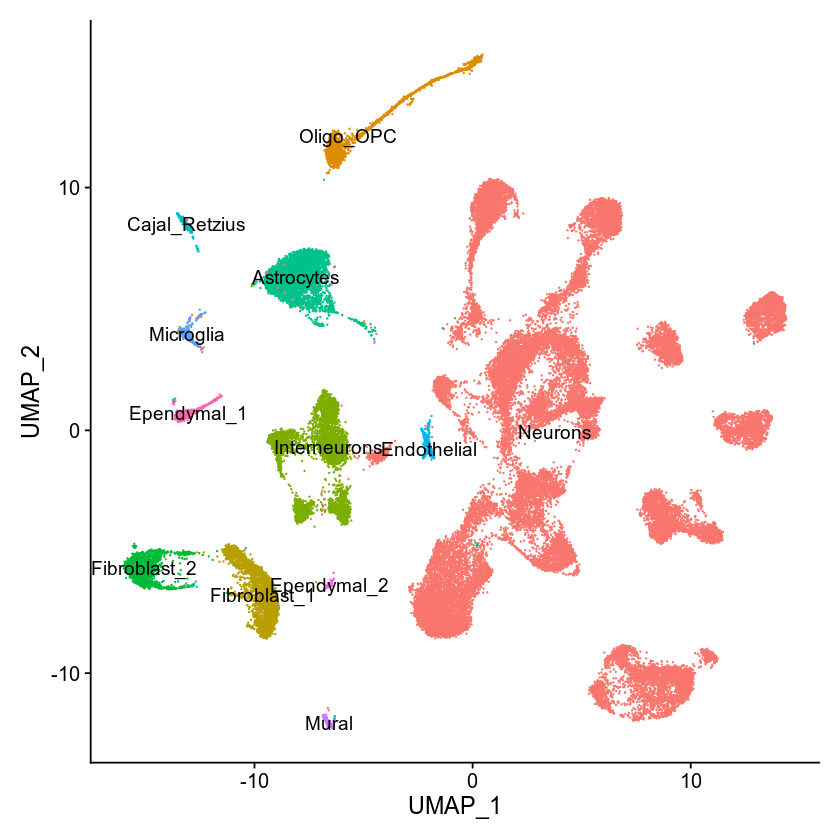

In [2]:
cells = readRDS("003A_allSamps_harmony_integration.rds")
Idents(cells) = "annotation2"
DimPlot(cells, label = T) + NoLegend()

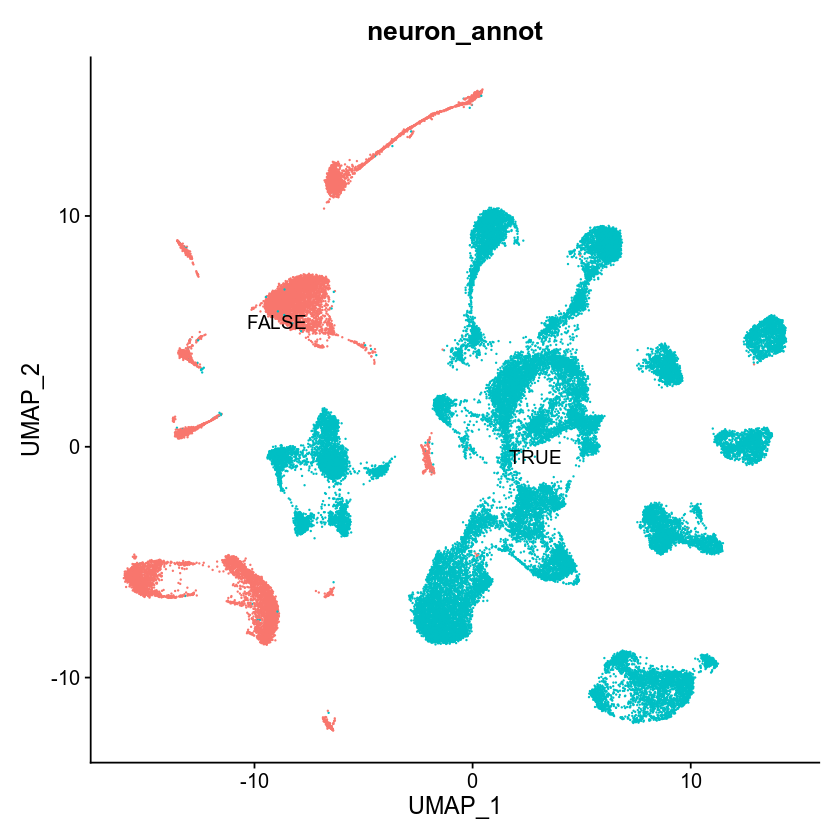

In [4]:
DimPlot(cells, label = T, group.by = "neuron_annot") + NoLegend()

In [5]:
#remove neurons
cells = subset(cells, neuron_annot==FALSE)
cells

An object of class Seurat 
24356 features across 12354 samples within 1 assay 
Active assay: RNA (24356 features, 2062 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

In [30]:
scratch.dir <- "./"
Output.dir.plots = "./003B_nonNeurons/003B1_"
Output.dir.objects = paste0(scratch.dir, "003B1_nonNeurons_")


In [7]:
DefaultAssay(cells) = "RNA"
nrow(cells@meta.data) %>% print()
cells@meta.data$sample %>% table() %>% print()

[1] 12354
.
 JK1  JK2  JK3  JK4  JK5  JK6  JK7  JK8 
 862 1974 4533 2136 2044  308  309  188 


In [8]:
#redo integration here, increase nfeatures = 4000, add percent.ribo to regressed variables

print("rescaling subset object")
cells <- NormalizeData(cells, verbose = FALSE)
cells <- FindVariableFeatures(cells, selection.method = "vst",
                              nfeatures = 4000, verbose = FALSE) 
cells <- ScaleData(object = cells, vars.to.regress = c("percent.mito", "nCount_RNA", "percent.ribo"))
cells <- RunPCA(cells,
                npcs = 50, verbose = FALSE)

print("scaling complete")

[1] "rescaling subset object"


Regressing out percent.mito, nCount_RNA, percent.ribo

Centering and scaling data matrix



[1] "scaling complete"


Saving 6.67 x 6.67 in image


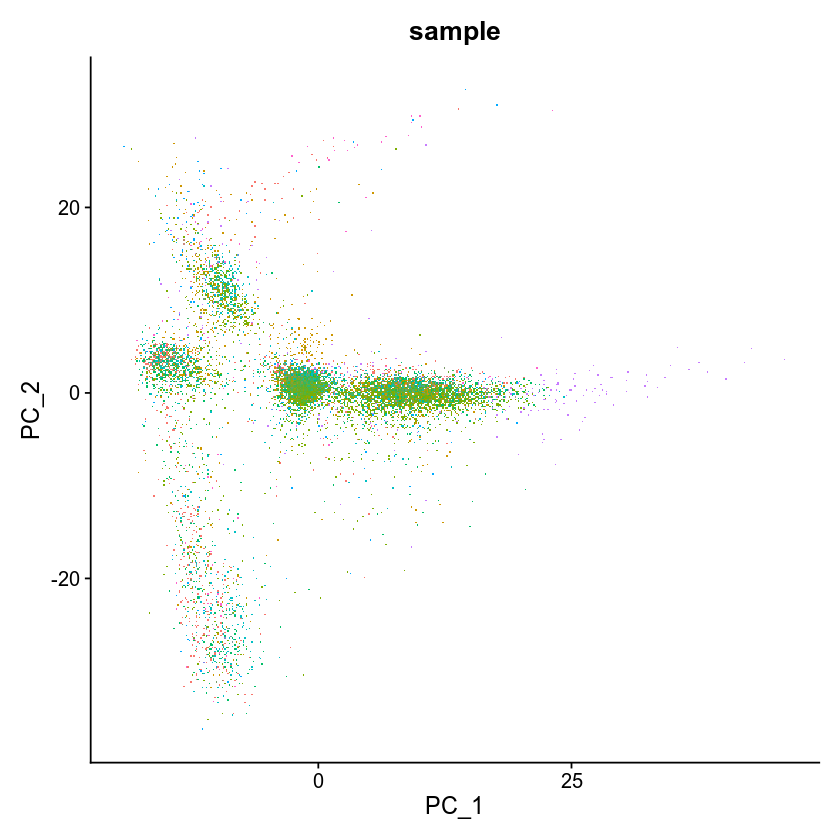

Saving 6.67 x 6.67 in image


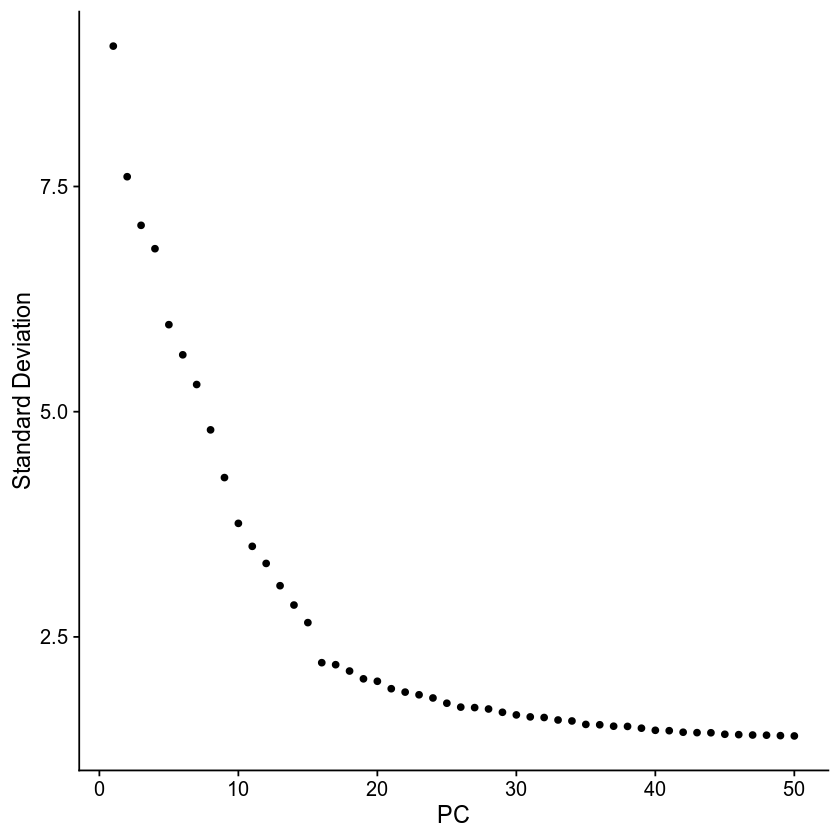

In [9]:
DimPlot(cells, reduction = "pca", group.by = "sample", raster = T) + NoLegend()
ggsave(paste0(Output.dir.plots, "allSamps_harmony_integration_scaled_pca.pdf"))
ElbowPlot(cells, ndims = 50)
ggsave(paste0(Output.dir.plots, "allSamps_harmony_integration_scaled_elbowPlot.pdf"))


Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony converged after 9 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”
Saving 6.67 x 6.67 in image


[1] "harmony finished, processing object"


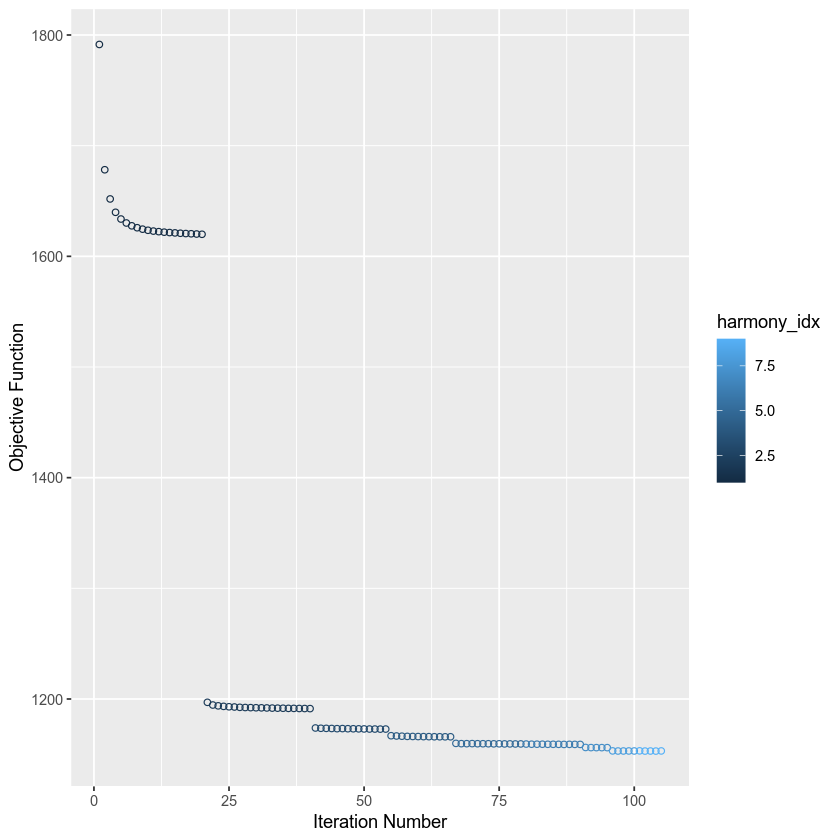

In [10]:
cells <- RunHarmony(cells, "sample", plot_convergence = TRUE)

ggsave(paste0(Output.dir.plots, "allSamps_harmony_integration_convergencePlot.pdf"))

print("harmony finished, processing object")


In [11]:
#determine optimal PCs to load into UMAP based on proposed method from https://hbctraining.github.io/scRNA-seq/lessons/elbow_plot_metric.html

# Determine percent of variation associated with each PC
pct <- cells[["harmony"]]@stdev / sum(cells[["harmony"]]@stdev) * 100
# Calculate cumulative percents for each PC
cumu <- cumsum(pct)
# Determine which PC exhibits cumulative percent greater than 90% and % variation associated with the PC as less than 5
co1 <- which(cumu > 90 & pct < 5)[1]
co2 <- sort(which((pct[1:length(pct) - 1] - pct[2:length(pct)]) > 0.1), decreasing = T)[1] + 1
pcs_harmony <- min(co1, co2)
print(paste0("Harmony PCs to load into UMAP: ", pcs_harmony))


[1] "Harmony PCs to load into UMAP: 29"


In [12]:
cells = cells %>%
    RunUMAP(reduction = "harmony", dims = 1:pcs_harmony) %>%
    FindNeighbors(reduction = "harmony", dims = 1:pcs_harmony) %>%
    FindClusters(resolution = 0.6) %>%
    identity()


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
11:55:26 UMAP embedding parameters a = 0.9922 b = 1.112

11:55:26 Read 12354 rows and found 29 numeric columns

11:55:26 Using Annoy for neighbor search, n_neighbors = 30

11:55:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:55:27 Writing NN index file to temp file /tmp/RtmpM21yUf/file2c423a73d0f1b6

11:55:27 Searching Annoy index using 1 thread, search_k = 3000

11:55:30 Annoy recall = 100%

11:55:31 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbor

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12354
Number of edges: 485281

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9261
Number of communities: 21
Elapsed time: 1 seconds


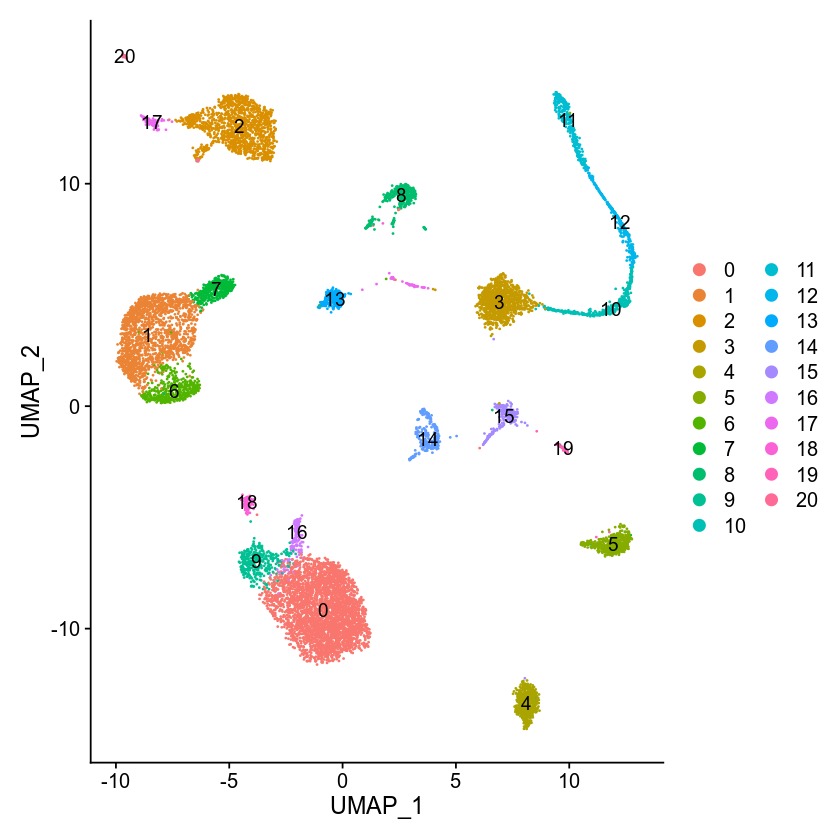

In [13]:
DimPlot(cells, label = T) #+ NoLegend()

In [14]:
cells$RNA_snn_res.0.6 %>% table()

.
   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
3287 1724 1321 1009  532  474  457  395  395  382  378  316  296  285  273  247 
  16   17   18   19   20 
 175  171  106   97   34 

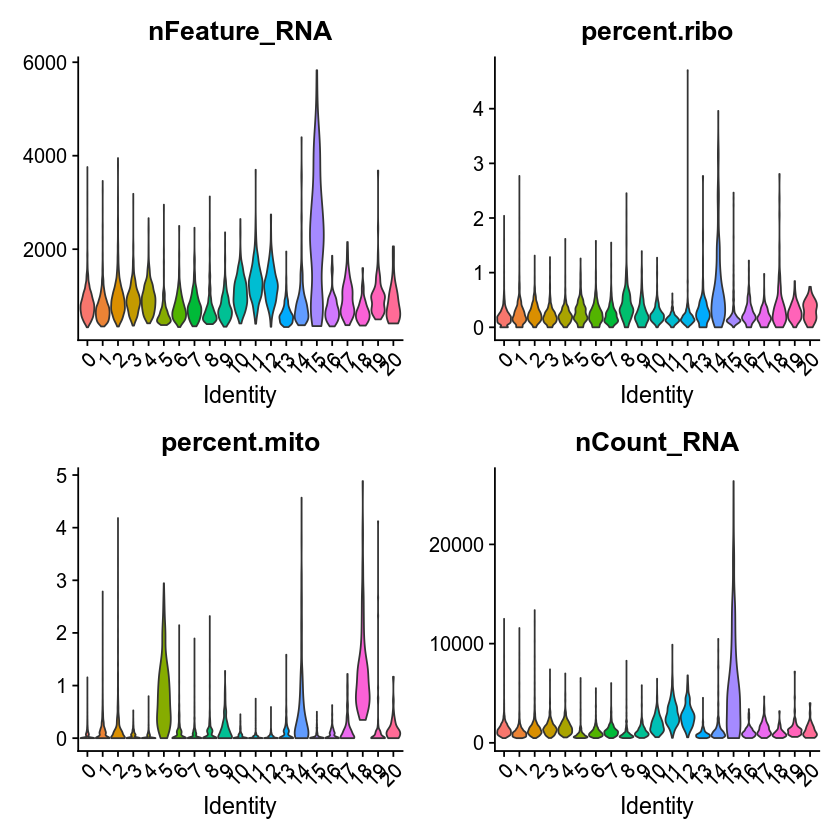

In [15]:
VlnPlot(cells,
        features = c("nFeature_RNA", "percent.ribo", "percent.mito","nCount_RNA"),         
        ncol = 2, pt.size = 0)


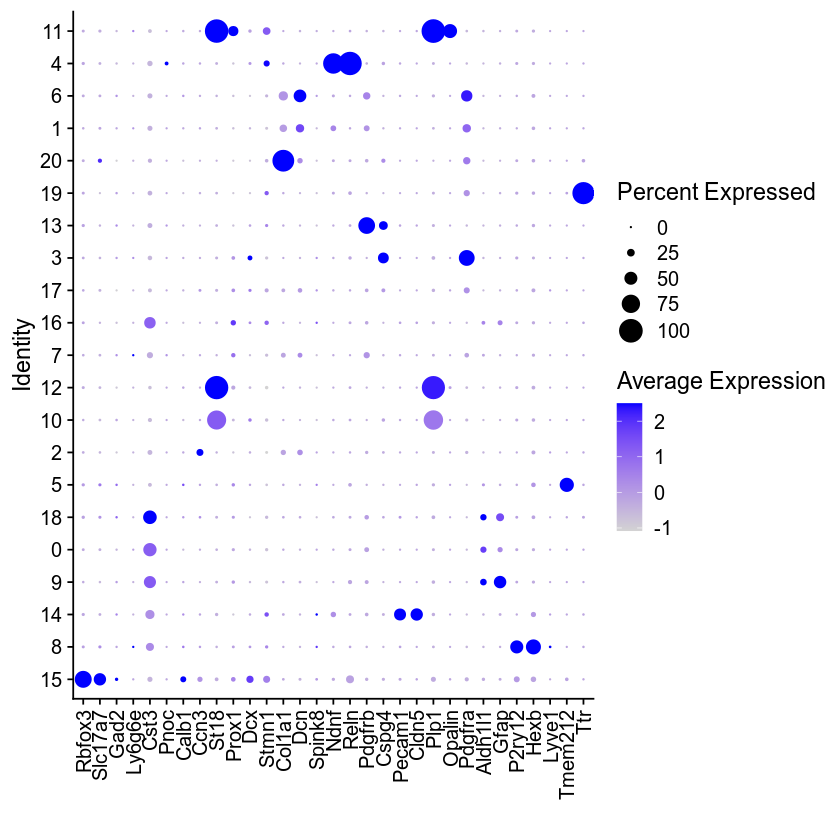

In [19]:
markers = c("Rbfox3", #neurons
           "Slc17a7", "Gad2",#    "Pcp4",
           "Ly6g6e",
           "Cst3",
           #"P2ry12",
           "Pnoc", #interneurons?           
           "Calb1","Ccn3",
           "St18", "Prox1", #DG cells
           "Dcx",
           "Stmn1",
           "Col1a1", "Dcn", #fibroblast
           "Spink8", #hippocampal pyramidal cells
           "Ndnf", "Reln", #Cajal-retzius cells
           "Pdgfrb","Cspg4", #mural cells
           "Pecam1", "Cldn5", #endothelial
           "Plp1", "Opalin", "Pdgfra", #oligo
           "Aldh1l1","Gfap", #astros
           "P2ry12", "Hexb", "Lyve1", #microglia
           #"Foxj1", "Myb", "Rfx2",
           "Tmem212", "Ttr" #ependymal/choroid
          )

DotPlot(cells, features = markers, cluster.idents = T)+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust =1)) + xlab("")


In [24]:
cells@meta.data %>% group_by(Genotype) %>% select(RNA_snn_res.0.6) %>% table()

Adding missing grouping variables: `Genotype`


        RNA_snn_res.0.6
Genotype    0    1    2    3    4    5    6    7    8    9   10   11   12   13
      KO 1681  869  642  618  307  252  247  184  228  207  190  175  144  144
      WT 1606  855  679  391  225  222  210  211  167  175  188  141  152  141
        RNA_snn_res.0.6
Genotype   14   15   16   17   18   19   20
      KO  125  109   94   79   58   93   17
      WT  148  138   81   92   48    4   17

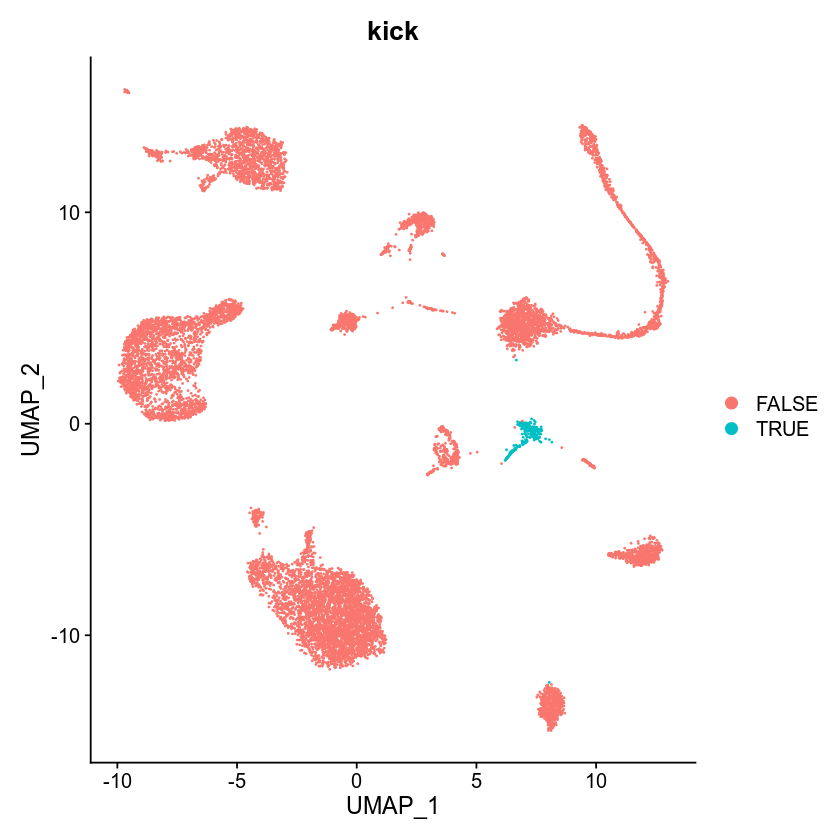

In [25]:
cells$kick = cells$`RNA_snn_res.0.6` %in% c(15) #removed because of neuronal genes
DimPlot(cells, group.by = 'kick')


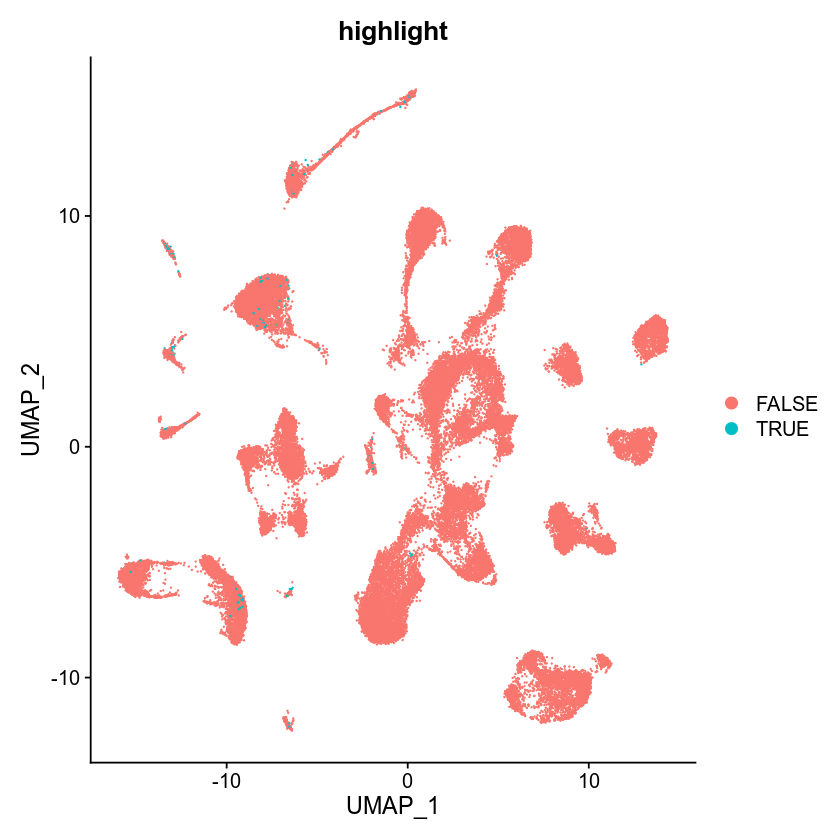

In [27]:
#show in total object
cells@meta.data %>% filter(kick == TRUE) %>% rownames(.) -> barcodes_show

total = readRDS("003A_allSamps_harmony_integration.rds")
total@meta.data$highlight = rownames(total@meta.data) %in% barcodes_show

DimPlot(total, group.by = 'highlight')

In [31]:
saveRDS(cells, paste0(Output.dir.objects, "Rd1_harmony_integration.rds")) #save scaled obj for safety


In [28]:
saveRDS(barcodes_show, "003B1_neuronal_barcodes_in_nonNeurons_Rd1.rds")

### This template is repeated to analyze non-neurons by iteratively removing cells, based on gene expression, QC features, etc. The same template is also used to analyze excitatory neurons and inhibitory neurons 